In [7]:
def get_embedding(model, face_pixels):
    import numpy as np
    from sklearn.preprocessing import Normalizer
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [30]:
class AI_Retraining:
    def __init__(self,path, rotation_range = 60, horizontal_flip = True):
        from mtcnn import MTCNN
        from sklearn.preprocessing import LabelEncoder
        from keras.preprocessing.image import ImageDataGenerator
        
        self.datagen = ImageDataGenerator(rotation_range= rotation_range, horizontal_flip= horizontal_flip)
        self.face_detector = MTCNN()
        self.encoder = LabelEncoder()
        self.X_image = []
        self.y_label = []
        self.path = path
        self.size = (160,160)
    def load_image(self):
        import cv2
        import glob
        try:
            file_path = self.path + "/*.*"
            for i in glob.glob(file_path):
                img = cv2.imread(i)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.X_image.append(img)
                label = i.split("/")[-1]
                label = label[:len(label)-9]
                self.y_label.append(label)
        except:
            print("Invalid Path")
    def extract_face(self):
        import cv2
        X=[]
        y=[]
        try:
            for i in range(len(self.X_image)):
                img = self.X_image[i]
                result = self.face_detector.detect_faces(img)
                k=0
                for k in range(len(result)):
                    if(k >= 1):
                        print("Required 1 person per image")
                    else:
                        x1, y1, width, height = result[k]['box']
                        x1, y1 = abs(x1), abs(y1)
                        x2, y2 = x1+width, y1+height
                        face = img[y1:y2, x1:x2]
                        face = cv2.resize(face,self.size)
                        X.append(face)
                        y.append(self.y_label[i])
            self.X_image = X
            self.y_label = y
        except Exception as e:
            print("code failed in extract_face")
            print(e)
    def face_augmentation(self, n = 7):
        import glob
        import os
        import numpy as np
        try:
            if(os.path.isdir("Desktop/Kashmir Augmented Image") == True):
                for i in glob.glob("Desktop/Kashmir Augmented Image/*.*"):
                    os.remove(i)
                os.rmdir("Desktop/Kashmir Augmented Image")
            self.augmentation_path = "Desktop/Kashmir Augmented Image" 
            os.mkdir(self.augmentation_path)
            for i in range(len(self.X_image)):
                img = self.X_image[i]
                img = np.reshape(img,(1,160,160,3))
                j=0
                for batch in self.datagen.flow(img, batch_size=1, save_to_dir= self.augmentation_path, save_prefix = self.y_label[i], save_format = "jpg"):
                    if(j >= n):
                        break
                    j+=1
            return self
        except Exception as e:
            print("Code is failed in face_augmentation")
            print(e)
            
    def load_augmented_image(self):
        import cv2
        import glob
        X = []
        y_label = []
        try:
            for i in glob.glob(self.augmentation_path+"/*.*"):
                img = cv2.imread(i)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                X.append(img)
                y = i.split("/")[-1]
                y = y.split("_")
                y = y[0] + y[1]
                y_label.append(y)
            self.X_image = X
            self.y_label = y_label
        except Exception as e:
            print("Code is failed in load_augmented_image")
            print(e)
            
    def features_to_numbers(self,path):
        from keras.models import load_model
        from keras.utils import np_utils
        import pickle
        
        self.facenet_model = load_model(path)
        X = []
        y = []
        for i in range(len(self.X_image)):
            X.append(get_embedding(self.facenet_model, self.X_image[i]))
        y = self.encoder.fit_transform(self.y_label)
        pickle.dump(self.encoder,open("Desktop/encoder","wb"))
        self.no_classes = len(set(y))
        y = np_utils.to_categorical(y, self.no_classes)
        self.X_image = X
        self.y_label = y
    def training_NN(self, epochs = 10, path = "Desktop/Kashmir Production/new_kashmir3.model", threshold = 0.95):
        from keras.models import Sequential
        from keras.layers import Dense
        import numpy as np
        import matplotlib.pyplot as plt
        
        self.nn_model = Sequential()
        self.nn_model.add(Dense(self.no_classes*3, input_dim = 128 , activation = "relu"))
        self.nn_model.add(Dense(self.no_classes*2, activation = "relu"))
        self.nn_model.add(Dense(self.no_classes, activation = "softmax"))
        self.nn_model.compile(loss = "categorical_crossentropy", optimizer= "adam", metrics=["accuracy"])
        print(self.nn_model.summary())
        self.X_image = np.array(self.X_image)
        self.y_label = np.array(self.y_label)
        history = self.nn_model.fit(self.X_image, self.y_label, epochs = epochs)
        plt.figure()
        plt.plot(history.history["accuracy"], color = "red", marker = "o" , label = "Accuracy")
        plt.grid(True, color = "black")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.yticks([0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
        plt.legend()
        plt.savefig("Desktop/Accuracy.png")
        plt.figure()
        plt.plot(history.history["loss"], color = "blue", marker = "o", label = "Loss")
        plt.grid(True, color = "black")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig("Desktop/Loss.png")
        if(history.history["accuracy"][len(history.history["accuracy"])-1] > threshold and history.history["accuracy"][len(history.history["accuracy"])-1] != 1.0):
            self.nn_model.save(path)
        else:
            print("Kindly Check the dataset is proper or update the model")


In [31]:
def prediction(path,model_path = "Desktop/Kashmir Production/new_kashmir3.model", face_net_model = "Desktop/facenet_keras.h5/model/facenet_keras.h5"):
    import cv2
    import numpy as np
    from keras.models import load_model
    import matplotlib.pyplot as plt
    from mtcnn import MTCNN
    import pickle
        
    nn_model = load_model(model_path)
    facenet_model = load_model(face_net_model)
    face_detector = MTCNN()
    encoder_file = open("Desktop/encoder","rb")
    encoder = pickle.load(encoder_file)
        
    X_test = []
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = face_detector.detect_faces(img)
    for k in range(len(result)):
        x1, y1, width, height = result[k]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]
        face = cv2.resize(face,(160,160))
        X_test.append(face)
    X_test = np.array(X_test)
    for i in range(len(X_test)):
        img = X_test[i]
        img = get_embedding(facenet_model, img)
        img = np.array(img)
        img = np.reshape(img, (1,128))
        y_pred = nn_model.predict(img)
        y_pred = y_pred[0]
        confidence = max(y_pred)
        y_pred = np.argmax(y_pred)
        y_pred = encoder.inverse_transform([y_pred])[0]
        print("Name of Person = ",y_pred)
        print("Accuracy = ",confidence*100,"%")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 117)               15093     
_________________________________________________________________
dense_95 (Dense)             (None, 78)                9204      
_________________________________________________________________
dense_96 (Dense)             (None, 39)                3081      
Total params: 27,378
Trainable params: 27,378
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
5/5 [==============================] - 0s 2ms/step - loss: 3.7673 - accuracy: 0.0256
Epoch 2/20
5/5 [==============================] - 0s 3ms/step - loss: 3.5140 - accuracy: 0.0577
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 3.3464 - accuracy: 0.1410
Epoch 4/20
5/5 [==============================] - 0s 2ms/step - loss: 3.1842 - accuracy

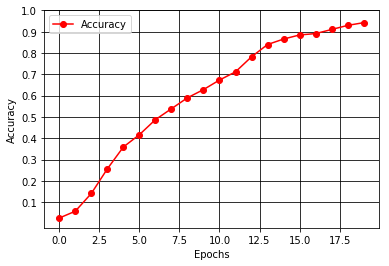

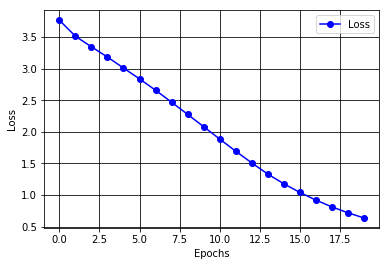

In [32]:
a = AI_Retraining("Desktop/kashmir_raw_dataset 2")
a.load_image()  #Loading Image
a.extract_face()    #Face Extraction
a.face_augmentation(3)    #Face Augmentation
a.load_augmented_image()  # Loading Augmented Image
a.features_to_numbers("Desktop/facenet_keras.h5/model/facenet_keras.h5")      #Loading Facenet Model
a.training_NN(20)             # Loading Neural Network 


In [4]:
prediction(path = "Desktop/kashmir_raw_dataset 2/Abdul Gani_Bhajmasta_img1.jpg")        #Prediction

Name of Person =  Abdul GaniBhajmasta
Accuracy =  75.22468566894531 %


In [40]:
prediction(path = "Desktop/kashmir_raw_dataset 2/Abdul Gani_Bhajmasta_img1.jpg")        #Prediction

AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [16]:
a = "E/DELL/Desktop/kashmir_raw_dataset 2/Abdul Gani_Bhajmasta_img1.jpg"

In [17]:
a = a.split("/")[-1]

In [18]:
a

'Abdul Gani_Bhajmasta_img1.jpg'

In [15]:
a.split("_")[0] + a.split("_")[1]

'Abdul GaniBhajmasta'